# ANLP: Sentiment Classification

In this assignment, you will be investigating NLP methods for distinguishing positive and negative reviews written about movies.

For assessment, you are expected to complete and submit this notebook file.  When answers require code, you may import and use library functions (unless explicitly told otherwise).  All of your own code should be included in the notebook rather than imported from elsewhere.  Written answers should also be included in the notebook.  You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers.  If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data.   In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell.  Otherwise do not change the code in these cells.

In [168]:
candidateno=277180 #this MUST be updated to your candidate number so that you get a unique data sample

In [169]:
#do not change the code in this cell
#preliminary imports

#set up nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import movie_reviews

#for setting up training and testing data
import random

#useful other tools
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import zip_longest
from nltk.probability import FreqDist
from nltk.classify.api import ClassifierI


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [170]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the
            pair is a list of the training data and the second is a list of the test data.
    """

    data = list(data)
    n = len(data)
    train_indices = random.sample(range(n), int(n * ratio))
    test_indices = list(set(range(n)) - set(train_indices))
    train = [data[i] for i in train_indices]
    test = [data[i] for i in test_indices]
    return (train, test)


def get_train_test_data():

    #get ids of positive and negative movie reviews
    pos_review_ids=movie_reviews.fileids('pos')
    neg_review_ids=movie_reviews.fileids('neg')

    #split positive and negative data into training and testing sets
    pos_train_ids, pos_test_ids = split_data(pos_review_ids)
    neg_train_ids, neg_test_ids = split_data(neg_review_ids)
    #add labels to the data and concatenate
    training = [(movie_reviews.words(f),'pos') for f in pos_train_ids]+[(movie_reviews.words(f),'neg') for f in neg_train_ids]
    testing = [(movie_reviews.words(f),'pos') for f in pos_test_ids]+[(movie_reviews.words(f),'neg') for f in neg_test_ids]

    return training, testing

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [171]:
#do not change the code in this cell
random.seed(candidateno)
training_data,testing_data=get_train_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 1400
The amount of testing data is 600
The representation of a single data item is below
(['david', 'mamet', 'has', 'long', 'been', 'my', ...], 'pos')


1)  
a) **Generate** a list of 10 content words which are representative of the positive reviews in your training data.

b) **Generate** a list of 10 content words which are representative of the negative reviews in your training data.

c) **Explain** what you have done and why

[20\%]

In regards to my **Sentiment Classification** assignment, I've been told to work on the **movie_reviews corpus**. The corpus I've been given has already been split into training and testing sets in a **70:30 ratio** using the split_data function. Our aim is to find content words that respresent positive and negative words in our training dataset.

Currently, each review / document in my training set is represented as a list of tokens.  In most basic applications, the sequence of words in a text is considered unimportant, and we use a bag-of-words representation of the document. In the cell below, I have used a function **FreqDist** from **nltk.Probability** to construct the bag-of-words in the training set while keeping the labels pos and neg intact (***FreqDist*** *is useful in text pre-processing, additionally it helps to understand how frequently the words has appeared which is further used to find most common words*)

In [172]:
#Document Representation
training_basic=[(FreqDist(wordlist),label) for (wordlist,label) in training_data]
testing_basic=[(FreqDist(wordlist),label) for (wordlist,label) in testing_data]

print(f"Frequency Distribution before pre-processing steps for Training Data: {training_basic[0]}")
print(f"Frequency Distribution before pre-processing steps for Testing Data: {testing_basic[0]}")

Frequency Distribution before pre-processing steps for Training Data: (FreqDist({',': 33, '.': 28, 'the': 28, 'a': 21, 'to': 20, 'is': 20, 'his': 16, 'of': 15, "'": 14, 'and': 13, ...}), 'pos')
Frequency Distribution before pre-processing steps for Testing Data: (FreqDist({'the': 46, ',': 43, "'": 25, '.': 23, 'and': 21, '(': 18, ')': 18, 'in': 18, 'a': 15, 'to': 15, ...}), 'pos')


Many of the words in the document representation output are punctuations and stopwords. To remove stopwords and punctuations i.e. to apply the preprocessing steps, I ran my **normalise function** on my **training_data**, the output printed is excluding the punctuations and stopwords which is stored in **filtered_words** variable. As the pre-processing steps are done, I have again used the FreqDist library and saved the output in the **training_norm** along with their frequency, this provides a cleaner representation of word frequencies in the preprocessed training data. The training_norm is then utilized in the next stages involved in generating the content words representing the positive and negative reviews.

Here, the normalise function is performing two key preprocessing steps:
1.   It converts all words to lowercase to ensure case insensitivity. This is acheived by using predefined python function **.lower()**.
2.   It then removes stopwords and non-alphabetic words from the lowered list to clean and prepare the text data for further analysis. This is done using **.isalpha()**.

In [173]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
#Document Pre-processing Techniques
def normalise(word_list):
  #making the word_list in lowercase (not needed but for proper analysis included this step)
  lower_case = [words.lower() for words in word_list]
  #removing stopwords
  filtered_words = [words for words in lower_case if words.isalpha() and words not in stop]
  return filtered_words

#printing the data after removing of punctuations and stopwords
print(f"Training Data after pre-processing steps: {normalise(training_data[0][0])}")
print(f"Testing Data after pre-processing steps: {normalise(testing_data[0][0])}")
print()

training_norm = [(FreqDist(normalise(word_list)),label) for (word_list,label) in training_data]
testing_norm = [(FreqDist(normalise(word_list)),label) for (word_list,label) in testing_data]

print(f"Frequency Distribution after pre-processing steps for Training Data: {training_norm[0]}")
print(f"Frequency Distribution after pre-processing steps for Testing Data: {testing_norm[0]}")

Training Data after pre-processing steps: ['david', 'mamet', 'long', 'favorite', 'screenwriter', 'director', 'distinctive', 'often', 'ingenious', 'dialogue', 'laid', 'back', 'style', 'direction', 'nearly', 'movies', 'absolutely', 'irresistible', 'tend', 'thickly', 'layered', 'deceptive', 'productions', 'require', 'audience', 'look', 'film', 'less', 'superficial', 'manner', 'plot', 'seems', 'require', 'order', 'discern', 'concealed', 'message', 'sometimes', 'even', 'concealed', 'storyline', 'although', 'real', 'plot', 'new', 'project', 'winslow', 'boy', 'slightly', 'conspicuous', 'endeavors', 'still', 'brilliantly', 'complex', 'consistently', 'riveting', 'motion', 'picture', 'honor', 'sacrifice', 'difference', 'commonly', 'known', 'justice', 'right', 'oh', 'rated', 'g', 'incidentally', 'first', 'time', 'mamet', 'decided', 'adapt', 'someone', 'else', 'work', 'namely', 'play', 'terrence', 'rattigan', 'set', 'century', 'casts', 'nigel', 'hawthorne', 'lead', 'role', 'arthur', 'winslow', 'ri

There are multiple ways to generate/identify content word list out which are using most frequent words logic and another using a threshold logic. Out of these two I have found the most frequent words logic more suitable as it concentrates on words that are more exclusive between the 2 classes.

To identify words that are more suggestive of one sentiment category than the other, I built a function called **most_freq_words**. This procedure comprised:

1.   Calculating the difference between the frequency distributions of positive and negative reviews in my training data.
2.   Sorting this difference and selecting top 'k' words that are more common in one sentiment category than the other.

Finally, I printed out the lists of 10 content words that are representative of positive and negative reviews in my training data which is stored in **content_words_pos** and **content_words_neg** variables respectively.

In [174]:
#most common words function
def most_freq_words(pos_freq,neg_freq,top_k):
  diff=pos_freq-neg_freq
  sort_diff=diff.most_common()
  only_words = [words for (words,label) in sort_diff[:top_k]]
  return only_words

pos_freq_dist=FreqDist()
neg_freq_dist=FreqDist()

for reviewDist,label in training_norm:
    if label=='pos':
        pos_freq_dist+=reviewDist
    else:
        neg_freq_dist+=reviewDist

content_words_pos = most_freq_words(pos_freq_dist,neg_freq_dist,10)
content_words_neg = most_freq_words(neg_freq_dist,pos_freq_dist,10)

print(f"1a) List of 10 content words which are representative of positive reviews in training data: {content_words_pos}")
print(f"1b) List of 10 content words which are representative of negative reviews in training data: {content_words_neg}")

#neg['movie', 'bad', 'plot', 'even', 'worst', 'stupid', 'script', 'could', 'least', 'get']
#pos['film', 'life', 'also', 'best', 'great', 'story', 'well', 'many', 'world', 'performance']

1a) List of 10 content words which are representative of positive reviews in training data: ['film', 'also', 'life', 'story', 'many', 'great', 'well', 'one', 'first', 'best']
1b) List of 10 content words which are representative of negative reviews in training data: ['movie', 'bad', 'plot', 'worst', 'script', 'get', 'could', 'even', 'nothing', 'supposed']


2)
a) **Use** the lists generated in Q1 to build a **word list classifier** which will classify reviews as being positive or negative.

b) **Explain** what you have done.

[12.5\%]


## **2a)**

In [175]:
class SimpleClassifier(ClassifierI):
    def __init__(self, pos, neg):
        self._pos = pos
        self._neg = neg

    def classify(self, doc):
        #doc is a FreqDist
        score = 0

        #this assigns an appropriate value to score
        for word,value in doc.items():
            if word in self._pos:
                score+=value
            if word in self._neg:
                score-=value

        return "neg" if score < 0 else  "pos"

    #since classify_many method is already provided in ClassifierI we don't actually need to define it
    def classify_many(self, docs):
        return [self.classify(doc) for doc in docs]
    def labels(self):
        return ("pos", "neg")


In [176]:
classifier = SimpleClassifier(content_words_pos, content_words_neg)
print(classifier.classify(FreqDist("This movie was great".split())))
print(classifier.classify(FreqDist("I hated this movie".split())))


pos
neg


In [177]:
class SimpleClassifier_mf(SimpleClassifier):
    def __init__(self,k):
        self._k=k

    def train(self,training_data):

        pos_freq_dist=FreqDist()
        neg_freq_dist=FreqDist()

        for reviewDist,label in training_data:
            if label=='pos':
                pos_freq_dist+=reviewDist
            else:
                neg_freq_dist+=reviewDist

        self._pos=most_freq_words(pos_freq_dist,neg_freq_dist,self._k)
        self._neg=most_freq_words(neg_freq_dist,pos_freq_dist,self._k)


In [178]:
movie_classifier=SimpleClassifier_mf(10)
movie_classifier.train(training_norm)

In [179]:
movie_classifier.classify(FreqDist("I hated this movie".split()))

'neg'

In [180]:
testing_data,labels=zip(*testing_norm)
movie_classifier.classify_many(testing_data)

['pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'neg',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',
 'pos',


Here I am creating a Word List Classifier using the list generated in above.
This is achieved by defining 2 classes SimpleClassifier and SimpleClassifier_mf.

The ***SimpleClassifier class*** represents a text classifier that may classify a document as "pos" or "neg" based on the presence of terms or words in positive and negative lists.In that, ***classify method*** passes the words of a document. The logic is then written in such a way that each instance of a negative word decreases score and each instance of a positive word increases score.

The ***classify_many method*** then applies the classification to several documents, and the labels method returns the labels that could be assigned ("pos" and "neg").

Post this, I extend the ***SimpleClassifier class*** to include a train function for generating wordlists from training data. In this, the train method starts by processing training data, which is made up of tuples containing document frequency distributions (reviewDist) and labels (label). It collects word frequencies for positive and negative reviews separately and uses ***most_freq_words*** function defined in our earlier step to select the top words for each category based on a parameter ***k***.

The 2 classes ***SimpleClassifier*** and ***SimpleClassifier_mf*** focuses on classifying and training the classifier respectively.

3)
a) **Calculate** the accuracy, precision, recall and F1 score of your classifier.

b) Is it reasonable to evaluate the classifier in terms of its accuracy?  **Explain** your answer and give a counter-example (a scenario where it would / would not be reasonable to evaluate the classifier in terms of its accuracy).

[20\%]

## **3a)**

In [181]:
class ConfusionMatrix:
    def __init__(self,predictions,goldstandard,classes=("pos","neg")):

        (self.c1,self.c2)=classes
        self.TP=0
        self.FP=0
        self.FN=0
        self.TN=0
        for p,g in zip(predictions,goldstandard):
            if g==self.c1:
                if p==self.c1:
                    self.TP+=1
                else:
                    self.FN+=1

            elif p==self.c1:
                self.FP+=1
            else:
                self.TN+=1


    def precision(self):
        p=0
        #this computes precision
        p = self.TP / (self.TP + self.FP)

        return p

    def recall(self):
        r=0
        #this computes recall
        r = self.TP / (self.TP + self.FN)
        return r

    def f1(self):
        f1=0
        p = self.precision()
        r = self.recall()
        #this computes f1
        f1 = (2*p*r)/(p+r)
        return f1

    def accuracy(self):
        acc = 0
        acc = (self.TP + self.TN)/(self.TP + self.TN + self.FN + self.FP)
        return acc

docs,goldlabel=zip(*testing_norm)
ConfusionM=ConfusionMatrix(classifier.classify_many(docs),goldlabel)
ConfusionM.recall()

print('Precision : ',ConfusionM.precision())
print('Recall :', ConfusionM.recall())
print('F1 :',ConfusionM.f1())
print('accuracy :',ConfusionM.accuracy())

Precision :  0.5738396624472574
Recall : 0.9066666666666666
F1 : 0.702842377260982
accuracy : 0.6166666666666667


In [182]:
classifier_WL = ConfusionM.accuracy()

## **3b)**

We need to evaluate how well a classifier works, below are the measures
1. **Accuracy** is the proportion of things we got correct or classified correctly.
2. **Error Rate** is a proportion of things that we got wrong.

Yes, Accuracy is a good way to assess our model, when the data is balanced. On the other side, if the data is skewed, accuracy alone cannot be trusted to select a well-performing model. Measure of assessing actually depends on what we would be interested in.
The two scenarios that I could discover are listed below.

1. **Protecting Positives More than Negatives & vice versa:**
Cases where its more crucial to protect the positives than the negatives & vice versa so we **dont** want to look at **overall accuracy**. suppose you have a film that is projected to earn an overwhelming amount of positive reviews.The movie studio would suffer a large loss if a positive review was not received (false negative).

2. Another case where there is a **difficulty with accuracy** that occurs frequently is when we are attempting to predict what is **relevant vs irrelevant**. If our data is **skewed**, we may have **99%** irrelevant papers and **1%** useful documents for that assignment. Saying that everything is irrelevant is the simplest method to get **99%** correct on the data. This strategy, however, is neither instructive nor beneficial, particularly when the purpose is to identify the minority class (relevant papers).

Depending on what you're looking for, accuracy and error rate may be too simple to quantify. Perhaps we should look more closely at what we are getting right and wrong, especially when the data is skewed, to find this we can use Confusion Matrix which tells us at what items the model is confusing in terms of the labels.

Here from the Confusion Matrix we derive number of other measures like

1. **Precision** - when prediction is made how reliable it is
2. **Recall** - if we are trying to find these things how many do we find
3. **F1 Score** - it's a trade off between the two.

4)
a)  **Construct** a Naive Bayes classifier (e.g., from NLTK).

b)  **Compare** the performance of your word list classifier with the Naive Bayes classifier.  **Discuss** your results.

[12.5\%]

## **4a)**

In [183]:
from nltk.classify import NaiveBayesClassifier

classifier_nb = NaiveBayesClassifier.train(training_norm)
classifier_nb.classify_many(docs)[:10] #to keep it presentable have included the [:10]

['pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos', 'pos']

## **4b)**

In [184]:
print(f"Accuracy of my Wordlist Classifier = {ConfusionM.accuracy()}") #Accuracy of Word List Classifier
print(f"Precision of my Wordlist classifier = {ConfusionM.precision()}") #Precision of Word List Classifier

Accuracy of my Wordlist Classifier = 0.6166666666666667
Precision of my Wordlist classifier = 0.5738396624472574


In [185]:
NB_predictions=classifier_nb.classify_many(docs)
NB_ConfusionM=ConfusionMatrix(NB_predictions,goldlabel)

In [186]:
print(f"Accuracy of Naive Bayes Classifier = {NB_ConfusionM.accuracy()}") #Accuracy of Naive Bayes Classifier
print(f"Precision of Naive Bayes classifier = {NB_ConfusionM.precision()}") #Precision of Naive Bayes Classifier

Accuracy of Naive Bayes Classifier = 0.6983333333333334
Precision of Naive Bayes classifier = 0.6274089935760171


The **Naive Bayes Classifier** **outperforms** the **Wordlist Classifier** in terms of precision. If you see it has a greater precision, which means that when it predicts a positive class, it is true about **62.74%** of the time, as opposed to the Wordlist Classifier's precision of about **57.38%**.

5)
a) Design and **carry out an experiment** into the impact of the **length of the wordlists** on the wordlist classifier.  Make sure you **describe** design decisions in your experiment, include a **graph** of your results and **discuss** your conclusions.

b) Would you **recommend** a wordlist classifier or a Naive Bayes classifier for future work in this area?  **Justify** your answer.

[25\%]


## **5a)**

In [187]:
def classifier_evaluate(cls, test_data):
    acc = 0
    docs,goldstandard=zip(*test_data) #note this neat pythonic way of turning a list of pairs into a pair of lists
    #pass all of the docs to the classifier and get back a list of predictions
    predictions=cls.classify_many(docs)
    #zip the predictions with the goldstandard labels and compare
    for prediction,goldlabel in zip(predictions,goldstandard):
        if prediction==goldlabel:
            acc+=1

    return acc / (len(test_data))

In [188]:
word_list_size = 50
samplesizes=[1,10,50,100,200,400,600]
classifiers={"classifier1": SimpleClassifier_mf(word_list_size)}
results={}
acc_res={}
pre_res={}
wordlen={}
recal_res={}
f1_res={}

number_of_runs = 3
for i in samplesizes:
    for j in range(number_of_runs):

        content_words_pos=most_freq_words(pos_freq_dist,neg_freq_dist,i) #create different size of positive wordlist
        content_words_neg=most_freq_words(neg_freq_dist,pos_freq_dist,i) #create different size of negative wordlist

        classifier = SimpleClassifier(content_words_pos,content_words_neg)
        #confusion matrix
        docs,goldlabels=zip(*testing_norm)
        CM=ConfusionMatrix(classifier.classify_many(docs),goldlabels)
        wordlen[i]=i
        pre_res[i] = pre_res.get(i,0)+(CM.precision()/number_of_runs)
        recal_res[i] = recal_res.get(i,0)+(CM.recall()/number_of_runs)
        f1_res[i] = f1_res.get(i,0)+(CM.f1()/number_of_runs)
        acc_res[i] = acc_res.get(i,0)+(CM.accuracy()/number_of_runs)
    results["word_list"] = wordlen
    results["accuracy"] = acc_res
    results["precision"] = pre_res
    results["recall"] = recal_res
    results["f1 score"] = f1_res

In [189]:
print(results)
df=pd.DataFrame(results)
# df=df.transpose()
df

{'word_list': {1: 1, 10: 10, 50: 50, 100: 100, 200: 200, 400: 400, 600: 600}, 'accuracy': {1: 0.55, 10: 0.6166666666666667, 50: 0.6266666666666667, 100: 0.6566666666666666, 200: 0.5933333333333334, 400: 0.5866666666666667, 600: 0.5866666666666667}, 'precision': {1: 0.5360576923076923, 10: 0.5738396624472574, 50: 0.576, 100: 0.5971074380165289, 200: 0.551660516605166, 400: 0.5477941176470589, 600: 0.5477941176470589}, 'recall': {1: 0.7433333333333333, 10: 0.9066666666666667, 50: 0.96, 100: 0.9633333333333334, 200: 0.9966666666666668, 400: 0.9933333333333332, 600: 0.9933333333333332}, 'f1 score': {1: 0.6229050279329608, 10: 0.702842377260982, 50: 0.7199999999999999, 100: 0.7372448979591837, 200: 0.7102137767220902, 400: 0.7061611374407584, 600: 0.7061611374407584}}


,word_list,accuracy,precision,recall,f1 score
1,1,0.550000,0.536058,0.743333,0.622905
10,10,0.616667,0.573840,0.906667,0.702842
50,50,0.626667,0.576000,0.960000,0.720000
100,100,0.656667,0.597107,0.963333,0.737245
200,200,0.593333,0.551661,0.996667,0.710214
400,400,0.586667,0.547794,0.993333,0.706161
600,600,0.586667,0.547794,0.993333,0.706161


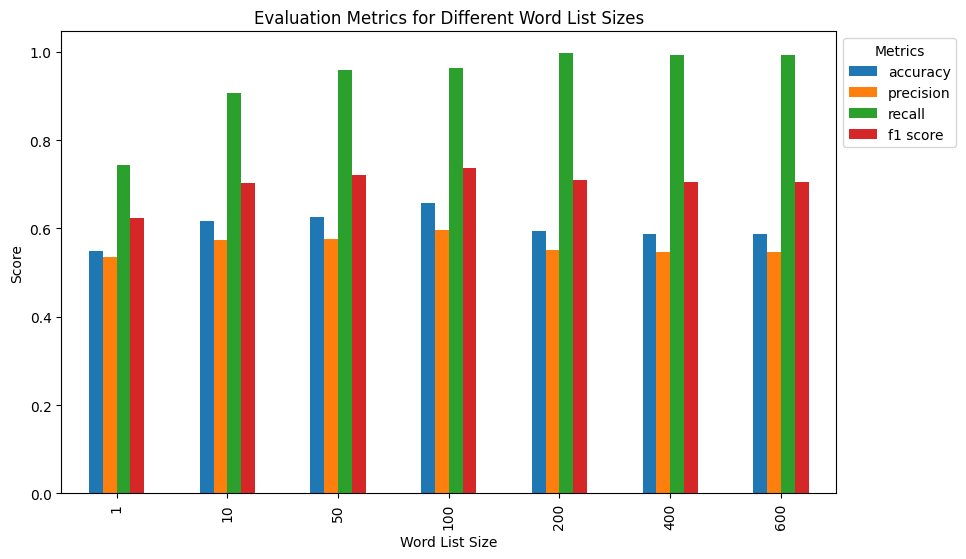

In [190]:
# Plotting a bar graph for each word list size
df.set_index('word_list').plot(kind='bar', figsize=(10, 6))
plt.title('Evaluation Metrics for Different Word List Sizes')
plt.xlabel('Word List Size')
plt.ylabel('Score')
plt.legend(title='Metrics', bbox_to_anchor=(1, 1))
plt.show()

Each line in the figure, depicts the trend of a given statistic (precision, recall, f1 score, accuracy) as the word list size grows. In this case, the precision, recall, f1 score, or accuracy rises as the word list size grows.

After a certain point, it begins to exhibit decreasing returns or begins to stabilize(sample size about 200). After this moment, performance appears to be slightly declining, indicating that extending the word list beyond that point may not significantly enhance performance.

For all sample sizes, the wordlist classifier using the 200 most frequent terms appears to outperform the wordlist classifier.

Considering the factors discussed, as the classification task involved a dynamic and evolving language context, and a sufficiently large and diverse dataset, I would recommend using a Naive Bayes classifier.

The dynamic and evolving nature of the language context connected with the activity motivates this option. It also excels at adapting to new words.

In [191]:
##This code will word count all of the markdown cells in the notebook saved at filepath

import io
from nbformat import current

from google.colab import drive
drive.mount('/content/drive')

filepath="/content/drive/MyDrive/Colab Notebooks/ANLPassignment2023.ipynb"
question_count=432

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Submission length is 1173
